# Setup and install for SVHN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install gpflow
%pip install plotnine

     |████████████████████████████████| 286 kB 14.1 MB/s 


In [ ]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line, facet_grid, ggtitle
from plotnine.themes import *

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [ ]:
paper_name = "gpSVHN"

In [ ]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")


This will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

[Here](https://github.com/aditya9211/SVHN-CNN/blob/master/svhn_model.ipynb) is a github project that uses the same data.



In [ ]:
data_location = '/content/drive/MyDrive/mlpapers/GP_Collab_SVHN'

In [ ]:
# Run this cell to load the dataset
train = loadmat(f'{data_location}/train_32x32.mat')
test = loadmat(f'{data_location}/test_32x32.mat')
extra = loadmat(f'{data_location}/extra_32x32.mat')

In [ ]:
# we have  png files with house numbers for the extra as well, in case of other ideas
# https://stackoverflow.com/questions/15612373/convert-image-png-to-matrix-and-then-to-1d-array


In [ ]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [ ]:
print(np.unique(test['y'][:12000])) # just checking that there is no order to the test data
print(train['X'].shape)
print(test['X'].shape)
print(extra['X'].shape)
print(extra['y'].shape)

[ 1  2  3  4  5  6  7  8  9 10]
(32, 32, 3, 73257)
(32, 32, 3, 26032)
(32, 32, 3, 531131)
(531131, 1)


## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [ ]:
train_data = train['X']
validation_data = test['X']
test_data = extra['X'][:,:,:,:30000]
train_targets = train['y']
validation_targets = test['y']
test_targets = extra['y'][:30000]

In [ ]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[2942, 9447, 11064, 15690, 25284, 35039, 37384, 40888, 56900, 72080]


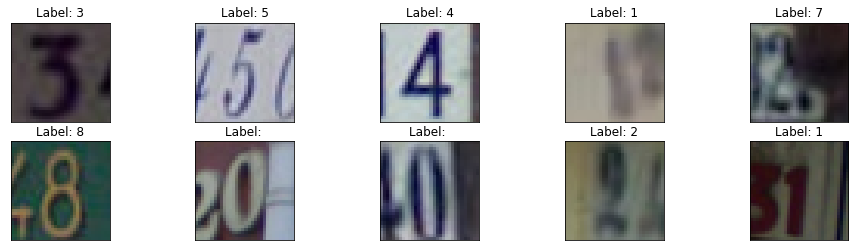

In [ ]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [ ]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)

test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)

validation_data_grey = validation_data.mean(axis=2)
validation_data_grey = np.expand_dims(validation_data_grey,axis=2)
validation_data_grey = np.moveaxis(validation_data_grey, 3, 0)

print(train_data.shape)
print(train_data_grey.shape)

(32, 32, 3, 73257)
(73257, 32, 32, 1)


Set the 10th class to zero (represents '0' digit)

In [ ]:
train_targets[train_targets == 10] = 0
validation_targets[validation_targets == 10] = 0
test_targets[test_targets == 10] = 0

In [ ]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[36, 1178, 6384, 18407, 24440, 27904, 30930, 36725, 47768, 53108]


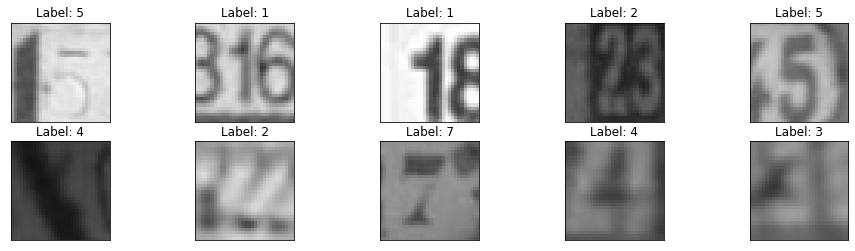

In [ ]:
plot_sample_grey(10)

In [ ]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


Let us do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

In [ ]:
# # let's do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

def get_model_seq(input_shape):
    model = Sequential([
                Flatten(name='F1',input_shape=input_shape),
                Dense(128, activation='relu', 
                      name = 'D1'),
                Dense(128, activation='relu', name = 'D2'),
                Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D4R'),                
                Dense(10,  activation='softmax', name = 'SFTMX1')
    ])    
    return model

model_seq = get_model_seq(train_data_grey[0,:,:,:].shape)

# model_seq.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# callbacks_seq = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
#                            mode='max',
#                            patience=60)
#                 ]

# history_seq = model_seq.fit(  train_data_grey, 
#                       train_targets,
#                       epochs=500, 
#                       validation_data=(validation_data_grey, validation_targets),
#                       callbacks=callbacks_seq,
#                       batch_size=512)

# plot_history(history_seq)
# model_seq.evaluate(test_data_grey,test_targets)

model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 F1 (Flatten)                (None, 1024)              0         
                                                                 
 D1 (Dense)                  (None, 128)               131200    
                                                                 
 D2 (Dense)                  (None, 128)               16512     
                                                                 
 D4R (Dense)                 (None, 48)                6192      
                                                                 
 SFTMX1 (Dense)              (None, 10)                490       
                                                                 
Total params: 154,394
Trainable params: 154,394
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [ ]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)

Some functions to get scores on the results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [ ]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames



In [ ]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")


# A basic DNN to fit SVHN

In [ ]:
def basic_DNNTemplate_A(model_name, inshape, num_classes = 10):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)
  d1_output = Dense(128, activation='relu', name = 'D1')(f1_output)
  d2_output = Dense(128, activation='relu', name = 'D2')(d1_output)
  d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D3R')(d2_output)
  model_output = Dense(10,  activation='softmax', name = 'SFTMX1')(d3r_output)
  model = Model(base_input, model_output, name = model_name)

  return model

In [ ]:
train_data_grey[0,:,:,:].shape

(32, 32, 1)

In [ ]:
# # saving 100 DNNs
for model_count in [i+1 for i in range(100)]:
  m1, h1 = compile_and_fit_model_basic( basic_DNNTemplate_A,  
                    f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/DNN_A_6_20210923210545_saved_model_after_fit/assets
# plot_history(h1)

In [ ]:
# saving the features of 100 DNNs for the train data

check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      # f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")      

In [ ]:
# dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{check_model_string}.*_features_D3R_Train.*$")

# check_model_string = "DNN_A_"
# not_check_model_string = ["arallel","Collab_"]
# for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
#   if os.path.isdir(dir_entry):
#     if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
#       print(dir_entry.name)
#       print(dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Train.*$"))
#       break


In [ ]:
# saving the features of 100 DNNs for the validation data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")      

In [ ]:
# saving the features of 100 DNNs for the test data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_D3R_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")      

In [ ]:
# getting the scores for the individual 100 DNNs on the test data set
scores_dnn_simple = []
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_dnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# A basic CNN to fit SVHN

In [ ]:
def basic_CNNTemplate_A(model_name, inshape, num_classes = 10):
  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  # Convolutional Layer #1
  c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name="C1")(base_input)

  # Pooling Layer #1
  mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP1")(c1_output)
  c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name="C2")(mxp1_output)
    
  #with tf.name_scope('Pool2 Layer'):
  mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP2")(c2_output)
  f1_output = Flatten(name='F1')(mxp2_output)

  # Dense Layer
  d1_output = Dense(units=256, activation="relu", name="D1")(f1_output)
  drp1_output = Dropout(rate=0.5, name="DRP1")(d1_output)

  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(drp1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


In [ ]:
# # saving 100 CNNs
for model_count in [i+1 for i in range(100)]:
  m1, h1 = compile_and_fit_model_basic( basic_CNNTemplate_A,  
                    f"CNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))


# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/DNN_A_6_20210923210545_saved_model_after_fit/assets
# plot_history(h1)

In [ ]:
# # saving the features of 100 CNNs for the training data

check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")      

In [ ]:
# # saving the features of 100 CNNs for the Validation data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")      

In [ ]:
# # saving the features of 100 CNNs for the Test data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")      

In [ ]:
# getting the scores for the individual 100 CNNs on the test data set
scores_cnn_simple = []
check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_cnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# ResNet50 fit SVHN grey

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization


In [ ]:
def basic_ResNet50Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(ResNet50(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)

def basic_VGG19Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(VGG19(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)



In [ ]:
# # saving 100 RestNet50
for model_count in [i+1 for i in range(40)]:
  m1, h1 = compile_and_fit_model_basic( basic_ResNet50Template_A,  
                    f"RestNet50_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    verbose_level = 1,
                    validation_data=(validation_data_grey, validation_targets))

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# plot_model(m1)


In [ ]:
#  ResNets do NOT allow feature extractions!
# model_entry = m1
# X_input = train_data_grey.copy()
# Y_input = train_targets.copy()
# layer_name = "resnet50"
# m1.input
# get_layer_by_name(m1.layers, "resnet50").output
# Model(m1.input, get_layer_by_name(m1.layers, layer_name).output)

In [ ]:
# getting the scores for the individual 40 ResNets on the test data set
scores_resnets_simple = []
check_model_string = "RestNet50_A"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_resnets_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_resnets_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_resnets_simple), 
               allow_pickle=True, 
               fix_imports=True)

# WideResNet fit SVHN grey

In [ ]:
import uuid
# uuid.uuid4()
# str(uuid.uuid4()).split("-")[0]

In [ ]:
# https://github.com/asmith26/wide_resnets_keras

# Wide residual network http://arxiv.org/abs/1605.07146
def _wide_basic(n_input_plane, n_output_plane, stride, identifier, 
                channel_axis = -1,
                weight_decay = 0.0005,
                weight_init="he_normal",
                use_bias = False,
                dropout_probability = 0.0
                ):
    def f(net):
        # format of conv_params:
        #               [ [nb_col="kernel width", nb_row="kernel height",
        #               subsample="(stride_vertical,stride_horizontal)",
        #               border_mode="same" or "valid"] ]
        # B(3,3): orignal <<basic>> block
        conv_params = [ [3,3,stride,"same"],
                        [3,3,(1,1),"same"] ]
        
        n_bottleneck_plane = n_output_plane

        # Residual block
        for i, v in enumerate(conv_params):
            if i == 0:
                if n_input_plane != n_output_plane:
                    net = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    net = Activation("relu")(net)
                    convs = net
                else:
                    convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    convs = Activation("relu")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name = f"CONV0_{identifier}_{uuid.uuid4()}")(convs)
            else:
                convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Activation("relu")(convs)
                if dropout_probability > 0:
                   convs = Dropout(dropout_probability, name=f"DRP{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name=f"CONV{str(i)}_{identifier}_{uuid.uuid4()}")(convs)

        # Shortcut Conntection: identity function or 1x1 convolutional
        #  (depends on difference between input & output shape - this
        #   corresponds to whether we are using the first block in each
        #   group; see _layer() ).
        if n_input_plane != n_output_plane:
            shortcut = Conv2D(n_output_plane, 
                              (1,1),
                              strides=stride,
                              padding="same",
                              kernel_initializer=weight_init,
                              kernel_regularizer=L2(weight_decay),
                              use_bias=use_bias,
                              name=f"CONVSHORTCUT_{identifier}_{uuid.uuid4()}")(net)
        else:
            shortcut = net

        return Add()([convs, shortcut])
    
    return f


# "Stacking Residual Units on the same stage"
def _layer(block, n_input_plane, n_output_plane, count, stride):
    def f(net):
        net = block(n_input_plane, n_output_plane, stride)(net)
        for i in range(2,int(count+1)):
            net = block(n_output_plane, n_output_plane, stride=(1,1))(net)
        return net
    
    return f


This will be WRN-28-10 WideResNet

In [ ]:
input_shape=train_data_grey[0,:,:,:].shape
weight_decay = 0.0005
weight_init="he_normal"
use_bias = False
k = 10
depth = 28             
n = (depth - 4) / 6
dropout_probability = 0.0
# batch_size = 128      
# nb_epochs = 200
channel_axis = -1

num_wrn_models = 10
no_classes=10
import functools

In [ ]:
# set up 40 WRN-28-10 models 
model_wrns = []

for i in range(num_wrn_models):
  inputs_wrn = Input(shape=input_shape,name=f"M{str(i)}_INPUT")
  n_stages=[16, 16*k, 32*k, 64*k]
  conv1_wrn = Conv2D(16, 
                  (3, 3), 
                  strides=1,
                  padding="same",
                  kernel_initializer=weight_init,
                  kernel_regularizer=L2(weight_decay),
                  use_bias=use_bias,
                  name="C1BLOCK")(inputs_wrn) # "One conv at the beginning (spatial size: 32x32)"
  # Add wide residual blocks
  block_fn = _wide_basic
  conv2_wrn = _layer(functools.partial(block_fn,identifier=f"C2BLOCK"), n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1,1))(conv1_wrn)# "Stage 1 (spatial size: 32x32)"
  conv3_wrn = _layer(functools.partial(block_fn,identifier=f"C3BLOCK"), n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2,2))(conv2_wrn)# "Stage 2 (spatial size: 16x16)"
  conv4_wrn = _layer(functools.partial(block_fn,identifier=f"C4BLOCK"), n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2,2))(conv3_wrn)# "Stage 3 (spatial size: 8x8)"

  batch_norm_wrn = BatchNormalization(axis=channel_axis,name=f"M{str(i)}_BN")(conv4_wrn)
  relu_wrn = Activation("relu")(batch_norm_wrn)
                                          
  # Classifier block
  pool_wrn = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same", name=f"CLASSIFIER_AVPL")(relu_wrn)
  flatten_wrn = Flatten(name=f"CLASSIFIER_FL")(pool_wrn)
  predictions_wrn = Dense(units=no_classes, kernel_initializer=weight_init, use_bias=use_bias,
                      kernel_regularizer=L2(weight_decay), activation="softmax", name="CLASSIFIER_D1")(flatten_wrn)
  model_wrn = Model(inputs=inputs_wrn, outputs=predictions_wrn)
  model_wrns.append(model_wrn)



In [ ]:
for model_count in [i for i in range(len(model_wrns))]:
  mwrn, hwrn = compile_and_fit_model_basic(  model_wrns[model_count], 
                                           f"WideResNet28-10_ID{str(uuid.uuid4()).split('-')[0]}_{str(model_count+11)}_{datetime.datetime.now():%Y%m%d%H%M%S}",
                                          train_data_grey[0,:,:,:].shape,
                                          train_data_grey,
                                          train_targets,
                                          save_max_epoch=False,
                                          save_final=True,
                                          patience_count = 35,
                                          early_stopping_obs = 'val_sparse_categorical_accuracy',
                                          log_history = True,
                                          verbose_level = 1,
                                          batch_size=256, 
                                          epochs=250, 
                                          class_weight=None,
                                          validation_data=(validation_data_grey, validation_targets))


In [ ]:
# # saving the features of WideResNets for the training data

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]

acceptable_chunk = 5000
idxs_for_train = np.unique(list(range(0,train_data_grey.shape[0],acceptable_chunk)) + [train_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_train[:-1])):
        print(f"{dir_entry.name}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          train_data_grey[idxs_for_train[i]:idxs_for_train[i+1],:,:,:], train_targets[idxs_for_train[i]:idxs_for_train[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Train{str(i)}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          train_data_grey[idxs_for_train[i]:idxs_for_train[i+1],:,:,:], train_targets[idxs_for_train[i]:idxs_for_train[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Train{str(i)}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        

In [ ]:

# # saving the features of WideResNets for the Validation data  

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]

acceptable_chunk = 5000
idxs_for_validation = np.unique(list(range(0,validation_data_grey.shape[0],acceptable_chunk)) + [validation_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_validation[:-1])):
        print(f"{dir_entry.name}__{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          validation_data_grey[idxs_for_validation[i]:idxs_for_validation[i+1],:,:,:], validation_targets[idxs_for_validation[i]:idxs_for_validation[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Validation{str(i)}_{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")     
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          validation_data_grey[idxs_for_validation[i]:idxs_for_validation[i+1],:,:,:], validation_targets[idxs_for_validation[i]:idxs_for_validation[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Validation{str(i)}_{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")     
      

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: 
#   tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:

# # saving the features of WideResNets for the Test data  

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"] 

acceptable_chunk = 5000
idxs_for_test = np.unique(list(range(0,test_data_grey.shape[0],acceptable_chunk)) + [test_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_test[:-1])):
      # # saving the features of WideResNets for the Test data      
        print(f"{dir_entry.name}__{idxs_for_test[i]}-{idxs_for_test[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          test_data_grey[idxs_for_test[i]:idxs_for_test[i+1],:,:,:], test_targets[idxs_for_test[i]:idxs_for_test[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"TestBatch{str(i)}_{idxs_for_test[i]}-{idxs_for_test[i+1]}")      
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          test_data_grey[idxs_for_test[i]:idxs_for_test[i+1],:,:,:], test_targets[idxs_for_test[i]:idxs_for_test[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"TestBatch{str(i)}_{idxs_for_test[i]}-{idxs_for_test[i+1]}")              

In [ ]:
# getting the scores for the individual WideResNets on the test data set
scores_wideresnets_simple = []
check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      print(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))
      scores_wideresnets_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_WideResNet2810_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_wideresnets_simple), 
               allow_pickle=True, 
               fix_imports=True)

WideResNet28-10_ID71928613_1_20211014230300_saved_model_after_fit
(0.9426668585503046, 0.9334333333333333, 0.9345350349420433, 0.9334333333333333)
WideResNet28-10_ID294f3208_1_20211015004120_saved_model_after_fit
(0.9670566130500473, 0.9665, 0.9665407049683383, 0.9665)
WideResNet28-10_IDe984f9ca_2_20211015035259_saved_model_after_fit
(0.9651505915218214, 0.9643666666666667, 0.9644065171070627, 0.9643666666666667)
WideResNet28-10_ID4cec947d_3_20211015065514_saved_model_after_fit
(0.9657519482052561, 0.9652666666666667, 0.9653032462704305, 0.9652666666666667)
WideResNet28-10_ID97463b53_4_20211015104216_saved_model_after_fit
(0.9532269145937123, 0.9491666666666667, 0.9496713027989148, 0.9491666666666667)
WideResNet28-10_ID0cd6adde_5_20211015144418_saved_model_after_fit
(0.9586881574112619, 0.9571666666666667, 0.9573273069552365, 0.9571666666666667)
WideResNet28-10_IDdc182e41_7_20211016062521_saved_model_after_fit
(0.9620292807039906, 0.9611, 0.9612027694527754, 0.9611)
WideResNet28-10_IDe

In [ ]:
# print(test_data_grey.shape)
# print(test_targets.shape)
# a=np.unique(list(range(0,test_data_grey.shape[0],5000)) + [test_data_grey.shape[0]]).tolist()
# print(a)
# a[:-1]

# Save the validation results for all the DNN, CNN, ResNet50, WideResnets to see whether it can be used for 'selecting' models

In [ ]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_sparse_categorical_accuracy.iloc[0]


In [ ]:
all_histories = os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history")

all_dnn_histories = [f for f in all_histories if "DNN_" in f and "arallel" not in f and "ollab" not in f]
all_cnn_histories = [f for f in all_histories if "CNN_" in f and "arallel" not in f and "ollab" not in f]
all_resnet50_histories = [f for f in all_histories if "RestNet50" in f and "arallel" not in f and "ollab" not in f]
all_WideResNet_histories = [f for f in all_histories if "WideResNet" in f and "arallel" not in f and "ollab" not in f]


In [ ]:
dnn_val_accs = pd.DataFrame( { "Type": "DNN", "File": all_dnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_dnn_histories  ] } )
cnn_val_accs = pd.DataFrame( { "Type": "CNN", "File": all_cnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_cnn_histories  ] } )
resnet50_val_accs = pd.DataFrame( { "Type": "ResNet50", "File": all_resnet50_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_resnet50_histories  ] } )
wideResNet_val_accs = pd.DataFrame( { "Type": "WideResNet", "File": all_WideResNet_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_WideResNet_histories  ] } )



In [ ]:
import datetime
val_accs_base_models = pd.concat([dnn_val_accs, cnn_val_accs, resnet50_val_accs, wideResNet_val_accs])
val_accs_base_models.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/validation_accs_base_{datetime.datetime.now():%Y%m%d%H%M%S}.csv", index=False)